In [7]:
import copy,re,sys,os
from pdastro import pdastroclass,pdastrostatsclass,unique,rmfile
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

#imnames=['nrc30/v1/jw01070001001_02101_00001_nrcalong_tweakregstep.fits',
#        'nrc30/v1/jw01070001001_06101_00001_nrcalong_tweakregstep.fits',
#        'nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.fits'
#        ]

#imnames=['nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.fits',
#         'nrc30/v1/jw01070001001_04101_00004_nrcalong_tweakregstep.fits']

imnames=['nrc30/v3/jw01070002001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070003001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070004001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070005001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v4/jw01070006001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070007001_02101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070008001_02101_00001_nrcalong_tweakregstep.fits']
"""
imnames=['nrc30/v3/jw01070002001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v4/jw01070003001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070004001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070005001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v4/jw01070006001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070007001_03101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v3/jw01070008001_03101_00001_nrcalong_tweakregstep.fits']
"""


photname=list(np.empty(len(imnames)))
phots = list(np.empty(len(imnames)))
copy_suffix = list(np.empty(len(imnames)))
for i in range(len(imnames)): 
    photname[i] = re.sub('\.fits$','.good.phot.txt',imnames[i])
    if photname[i] == imnames[i]: 
        raise RuntimeError(f'BUG!!! {photname[i]}')
    im = fits.open(imnames[i])
    aperture = im['PRIMARY'].header['APERNAME']
    pupil = re.sub('MASK','',im['PRIMARY'].header['PUPIL'])
    obsnum = im['PRIMARY'].header['OBSERVTN']
    phots[i]= pdastrostatsclass()
    phots[i].load(photname[i])
    if 'gaia_source_id' in phots[i].t.columns:
        phots[i].t['gaia_source_id']=phots[i].t['gaia_source_id'].astype(pd.Int64Dtype())
    copy_suffix[i] = f'{obsnum}_{pupil}'
    print(f'{photname[i]}: {aperture} {pupil} {obsnum} ({len(phots[i].t)} rows): {copy_suffix[i]}')
    

nrc30/v3/jw01070002001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 002 (138 rows): 002_RND
nrc30/v3/jw01070003001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 003 (185 rows): 003_RND
nrc30/v3/jw01070004001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 004 (181 rows): 004_RND
nrc30/v3/jw01070005001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 005 (199 rows): 005_RND
nrc30/v4/jw01070006001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 006 (68 rows): 006_RND
nrc30/v3/jw01070007001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 007 (130 rows): 007_RND
nrc30/v3/jw01070008001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 008 (108 rows): 008_RND


In [8]:
phots[1].write()
# add all coordinate columns to each phot file: x/y_idl, v2/v3

 aper_sum_3.5px  annulus_median_3.5px  aper_bkg_3.5px  aper_sum_bkgsub_3.5px  flux_err_3.5px       mag     dmag           x           y  sharpness  roundness1  roundness2        ra        dec      x_idl      y_idl   gaia_ra   gaia_dec  gaia_ID      gaia_source_id  gaia_ra_error  gaia_dec_error    gaia_g  gaia_g_err   gaia_rp  gaia_rp_err  gaia_g_rp  gaia_g_rp_err   __weights  d_rot_tmp  __tmp_residuals  delta_mag      gaia_x      gaia_y        dx        dy
     215.451432              0.368091       14.328144             201.123288        4.572728 -5.758656 0.024691 1141.518702    7.780219   0.683589   -0.030977    0.101656 80.492326 -69.494360   7.337865 -63.927404 80.492321 -69.494360   2490.0 4657988141103148032       0.062444        0.059678 17.284128    0.001308 16.389351     0.013020   0.894777       5.489106  201.123288  -3.191856         0.046021 -23.042784 1141.396209    7.834127 -0.122492  0.053908
      60.744626              0.185840        7.233936              53.510690  

0

In [9]:
def find_matches(phot0, phot1, suffix4copycol, ixs_phot0=None, ixs_phot1=None, refcat_prefix='gaia',
                cols2copy=['ra','dec','x_idl','y_idl']):
    Ndouble = 0
    idcol = f'{refcat_prefix}_source_id'
    ixs_phot0 = phot0.getindices(ixs_phot0)
    ixs_phot1 = phot1.getindices(ixs_phot1)
    ix0_singlematch=[]
    ix1_singlematch=[]
    for ix0 in ixs_phot0:
        ID = phot0.t.loc[ix0,idcol]
        ix1_match = phot1.ix_equal(idcol,ID,indices=ixs_phot1)
        #print(f'{ID}: {len(ixs_match)}')
        if len(ix1_match)==1:
            ix0_singlematch.append(ix0)
            ix1_singlematch.append(ix1_match[0])
    print(f'matches: {len(ix0_singlematch)}')
    for sourcecol in ['x','y','x_idl','y_idl','ra','dec']:
        destcol = f'{sourcecol}_{suffix4copycol}'
        phot0.t.loc[ix0_singlematch,destcol]=list(phot1.t.loc[ix1_singlematch,sourcecol])
    return(ix0_singlematch)

diff_mean = pdastrostatsclass()
diff_mean.t['diffname']=None
diff_mean.param2columnmapping = diff_mean.intializecols4statparams()

outcols= ['mag','dmag','x','y','ra','dec','x_idl','y_idl','gaia_ra','gaia_dec','gaia_source_id']
ixs0_keep = []
for i in range(1,len(imnames)):
    ixs0_match = find_matches(phots[0],phots[i],copy_suffix[i])
    for col0 in ['x','y','x_idl','y_idl']:
        # get column names
        coli = f'{col0}_{copy_suffix[i]}'
        dcol = f'diff_{col0}_{copy_suffix[i]}'
        #print(col0,coli,dcol)
        
        # calculate difference
        phots[0].t.loc[ixs0_match,dcol] =  phots[0].t.loc[ixs0_match,coli] - phots[0].t.loc[ixs0_match,col0] 
        
        # keep the columns for the output
        outcols.extend([coli,dcol])
        
        # do statistics!
        phots[0].calcaverage_sigmacutloop(dcol,verbose=3,indices=ixs0_match,percentile_cut_firstiteration=80)
        print(phots[0].statstring())

        ix_result = diff_mean.newrow({'diffname':dcol})
        diff_mean.statresults2table(phots[0].statparams,
                                    diff_mean.param2columnmapping,
                                    destindex=ix_result)
    ixs0_keep.extend(ixs0_match)
ixs0_keep = unique(ixs0_keep)
#sys.exit(0)
#ix0_match = find_matches(phots[0],phots[1],copy_suffix='001')
print(phots[0].t.columns)
#phots[0].write(columns=outcols,indices=ixs0_keep)
outfilename = re.sub('\.txt$','.matches.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
print(f'Saving matches to {outfilename}')
phots[0].write(outfilename,columns=outcols,indices=ixs0_keep)

diff_mean.write()
outfilename = re.sub('\.txt$','.mean.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
print(f'Saving mean value stats to {outfilename}')
diff_mean.write(outfilename)
#phots[0].write(columns=['x','y','ra','dec','x_idl','y_idl','x_idl001_BAR','d_x_idl_x_idl001_BAR'])
#phots[0].write()
#print(phots[0].t['x_idl001'])

matches: 109
Keeping 109 out of 109, skippin 0 because of null values in columns diff_x_003_RND
median: -5.439671
80.000000 percentile cut: max residual for cut: 0.204835
median: -5.397210
i:00 mean:-5.397210(0.013445) stdev:0.124683(0.009452) X2norm:0.99 Nchanged:0 Ngood:87 Nclip:22

mean: -5.485229
i:01 mean:-5.485229(0.013337) stdev:0.136662(0.009386) X2norm:1.00 Nchanged:19 Ngood:106 Nclip:3

mean: -5.488112
i:02 mean:-5.488112(0.013525) stdev:0.139247(0.009519) X2norm:1.00 Nchanged:1 Ngood:107 Nclip:2

mean: -5.488112
i:03 mean:-5.488112(0.013525) stdev:0.139247(0.009519) X2norm:1.00 Nchanged:0 Ngood:107 Nclip:2
i:03 mean:-5.488112(0.013525) stdev:0.139247(0.009519) X2norm:1.00 Nchanged:0 Ngood:107 Nclip:2
Keeping 109 out of 109, skippin 0 because of null values in columns diff_y_003_RND
median: 0.286120
80.000000 percentile cut: max residual for cut: 0.079734
median: 0.290854
i:00 mean:0.290854(0.004748) stdev:0.044035(0.003338) X2norm:0.99 Nchanged:0 Ngood:87 Nclip:22

mean: 0.2

i:01 mean:7.237946(0.006102) stdev:0.050320(0.004284) X2norm:1.00 Nchanged:1 Ngood:69 Nclip:19

mean: 7.237946
i:02 mean:7.237946(0.006102) stdev:0.050320(0.004284) X2norm:1.00 Nchanged:0 Ngood:69 Nclip:19
i:02 mean:7.237946(0.006102) stdev:0.050320(0.004284) X2norm:1.00 Nchanged:0 Ngood:69 Nclip:19
Keeping 88 out of 88, skippin 0 because of null values in columns diff_y_007_RND
median: -0.306496
80.000000 percentile cut: max residual for cut: 0.077230
median: -0.303499
i:00 mean:-0.303499(0.004140) stdev:0.034388(0.002906) X2norm:0.99 Nchanged:0 Ngood:70 Nclip:18

mean: -0.309308
i:01 mean:-0.309308(0.005054) stdev:0.044635(0.003551) X2norm:1.00 Nchanged:9 Ngood:79 Nclip:9

mean: -0.310688
i:02 mean:-0.310688(0.005509) stdev:0.049582(0.003872) X2norm:1.00 Nchanged:3 Ngood:82 Nclip:6

mean: -0.310688
i:03 mean:-0.310688(0.005509) stdev:0.049582(0.003872) X2norm:1.00 Nchanged:0 Ngood:82 Nclip:6
i:03 mean:-0.310688(0.005509) stdev:0.049582(0.003872) X2norm:1.00 Nchanged:0 Ngood:82 Nclip:

0

In [22]:
plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}

def initplot(nrows=1, ncols=1, figsize4subplot=5, **kwargs):
    print('hello')
    sp=[]
    xfigsize=figsize4subplot*ncols
    yfigsize=figsize4subplot*nrows
    plt.figure(figsize=(xfigsize,yfigsize))
    counter=1
    for row in range(nrows):
        for col in range(ncols):
            sp.append(plt.subplot(nrows, ncols, counter,**kwargs))
            counter+=1

    for i in range(len(sp)):
        plt.setp(sp[i].get_xticklabels(),'fontsize',12)
        plt.setp(sp[i].get_yticklabels(),'fontsize',12)
        sp[i].set_xlabel(sp[i].get_xlabel(),fontsize=14)
        sp[i].set_ylabel(sp[i].get_ylabel(),fontsize=14)
        sp[i].set_title(sp[i].get_title(),fontsize=14)

    return(sp)
"""
sp = initplot(1,3)
# plot the residuals
title = f'{photname[0]}'
wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[0],**plot_style['do_not_use_data'])
wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[0],ylabel='mag',title=title,**plot_style['good_data'])
wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[1],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[2],ylim=dx_plotlim,**plot_style['do_not_use_data'])
wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[2],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
for i in range(3): sp[i].get_legend().remove()
plt.tight_layout()
plt.show()
"""

def plot_dxdy(phot, ixs, dcol_x, dcol_y, sp=None, outfilename=None):
    if sp is None: sp = initplot(2,2)
    phot.t.loc[ixs].plot('x',dcol_x,ax=sp[0],ylabel=dcol_x,**plot_style['good_data'])
    phot.t.loc[ixs].plot('y',dcol_x,ax=sp[1],ylabel=dcol_x,**plot_style['good_data'])
    phot.t.loc[ixs].plot('x',dcol_y,ax=sp[2],ylabel=dcol_x,**plot_style['good_data'])
    phot.t.loc[ixs].plot('y',dcol_y,ax=sp[3],ylabel=dcol_x,**plot_style['good_data'])
    plt.tight_layout()
    
    if outfilename is not None:
        print(f'Saving {outfilename}')
        plt.savefig(outfilename)
    return(sp)


hello
Saving nrc30/v3/jw01070002001_02101_00001_nrcalong_tweakregstep.good.phot.003_RND.png
hello
Saving nrc30/v3/jw01070002001_02101_00001_nrcalong_tweakregstep.good.phot.004_RND.png
hello
Saving nrc30/v3/jw01070002001_02101_00001_nrcalong_tweakregstep.good.phot.005_RND.png


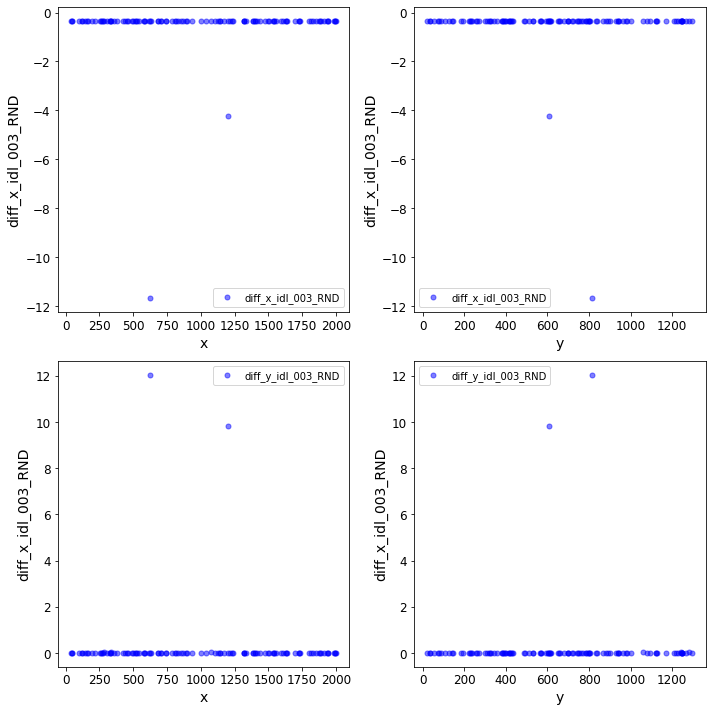

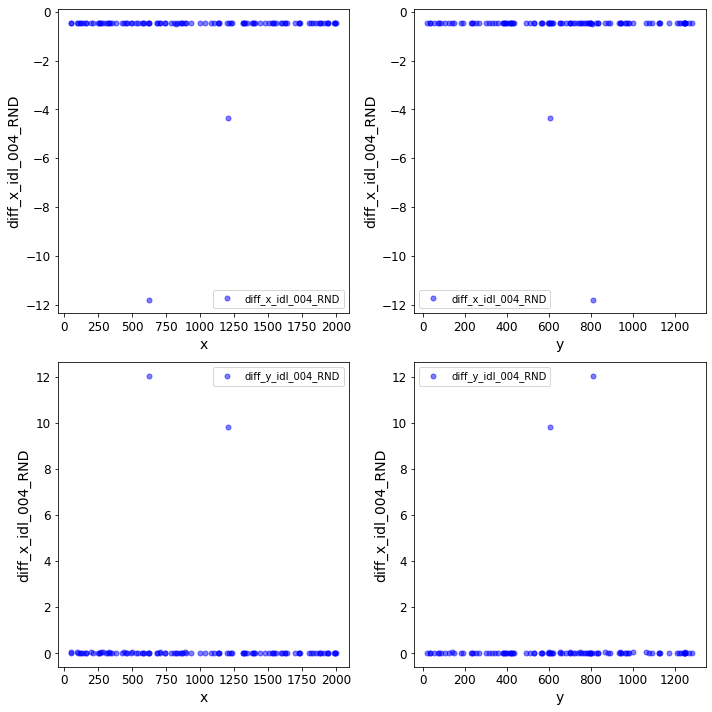

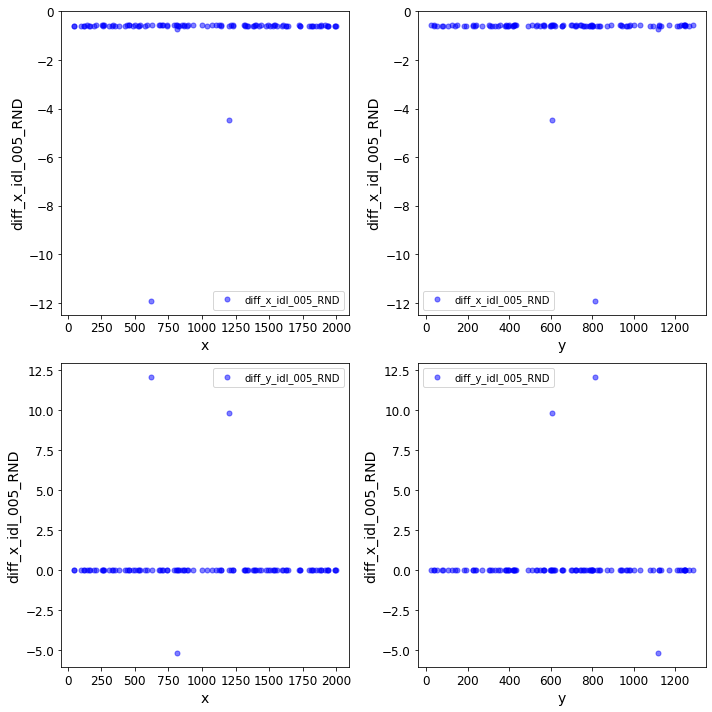

In [23]:
#print(phots[0].t.columns)
saveflag=True
for i in range(1,len(copy_suffix)):
    dcol_x = f'diff_x_idl_{copy_suffix[i]}'
    dcol_y = f'diff_y_idl_{copy_suffix[i]}'
    if saveflag:
        outfilename = re.sub('\.txt$',f'.{copy_suffix[i]}.png',photname[0])
        if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
        if os.path.isfile(outfilename):
            rmfile(outfilename)
    else:
        outfilename=None

    plot_dxdy(phots[0],ixs0_keep,dcol_x,dcol_y,outfilename=outfilename)